In [28]:
from astropy.io import fits
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import processing_functions as pf
import scipy.stats as stats
import scipy.special as sps
import scipy.optimize as opt
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [3]:
lc1 = '/home/ravioli/astro/ksp/grb/data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc'
lc1_data = fits.open(lc1)[1].data
max_1 = int(np.where(lc1_data['RATE'] == np.max(lc1_data['RATE']))[0])
start = max_1-110
end = max_1+22

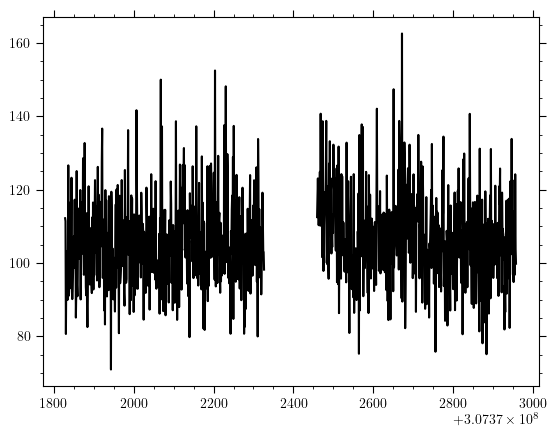

In [26]:
grb = np.ones_like(lc1_data['RATE'][start:end])*np.nan
data = np.concatenate((lc1_data['RATE'][start-500: start], grb, lc1_data['RATE'][end:end+500]))
plt.plot(lc1_data['TIME'][start-500:end+500], data, 'k')
plt.show()

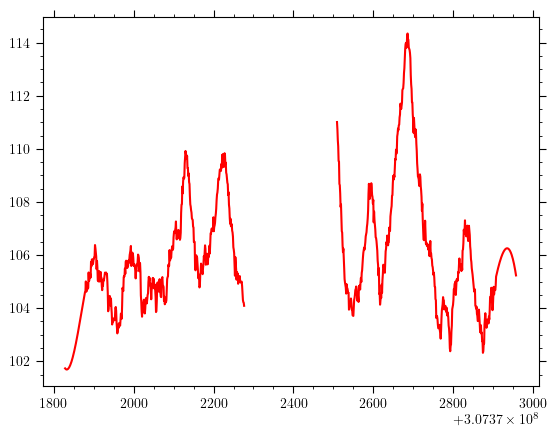

In [27]:
filtered = savgol_filter(data, 101, 3)
plt.plot(lc1_data['TIME'][start-500:end+500], filtered, 'r')
plt.show()

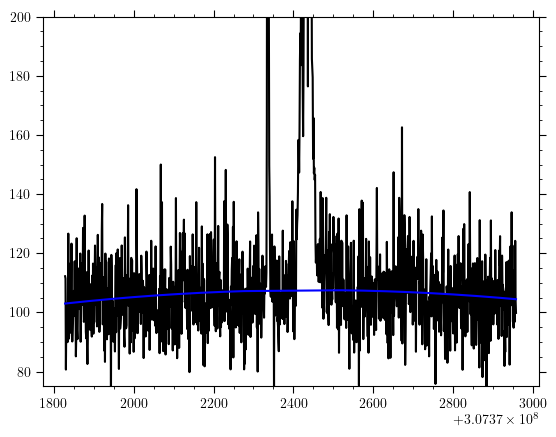

In [25]:
idx = np.isfinite(filtered)
x = lc1_data['TIME'][start-500:end+500][idx]
y = filtered[idx]
ab = np.polyfit(x, y, 5)
plt.plot(lc1_data['TIME'][start-500:end+500], lc1_data['RATE'][start-500:end+500], 'k')
plt.plot(x, np.polyval(ab, x), 'b')
plt.ylim(75,200)
plt.show()

In [3]:
data, south_atlantic_start, south_atlantic_end = pf.filter_and_detrend(lc1, start, end, 3)
if end<south_atlantic_start:
    total_noise = np.concatenate((data['RATE'][:start], data['RATE'][end:south_atlantic_start], data['RATE'][south_atlantic_end:]))
elif start>south_atlantic_end:
    total_noise = np.concatenate((data['RATE'][:south_atlantic_start], data['RATE'][south_atlantic_end:start], data['RATE'][end:]))
else:
    print('Inputted start and end times are not valid')
    snr = 0
    total_noise = 0
    popt = [0]
    bin_center = 0
    
signal = np.max(data['RATE'][start:end])

In [4]:
i=0
while i<1000:
    params = stats.gamma.fit(total_noise)
    k = params[0]
    loc = params[1]
    theta = params[2]
    mean = np.mean(total_noise)
    diff = k*theta - mean
    if np.round(diff, 0)==0: break
    total_noise += diff
    i+=1

48.36570224637171 4.9032110286300705 -0.13354697695377113


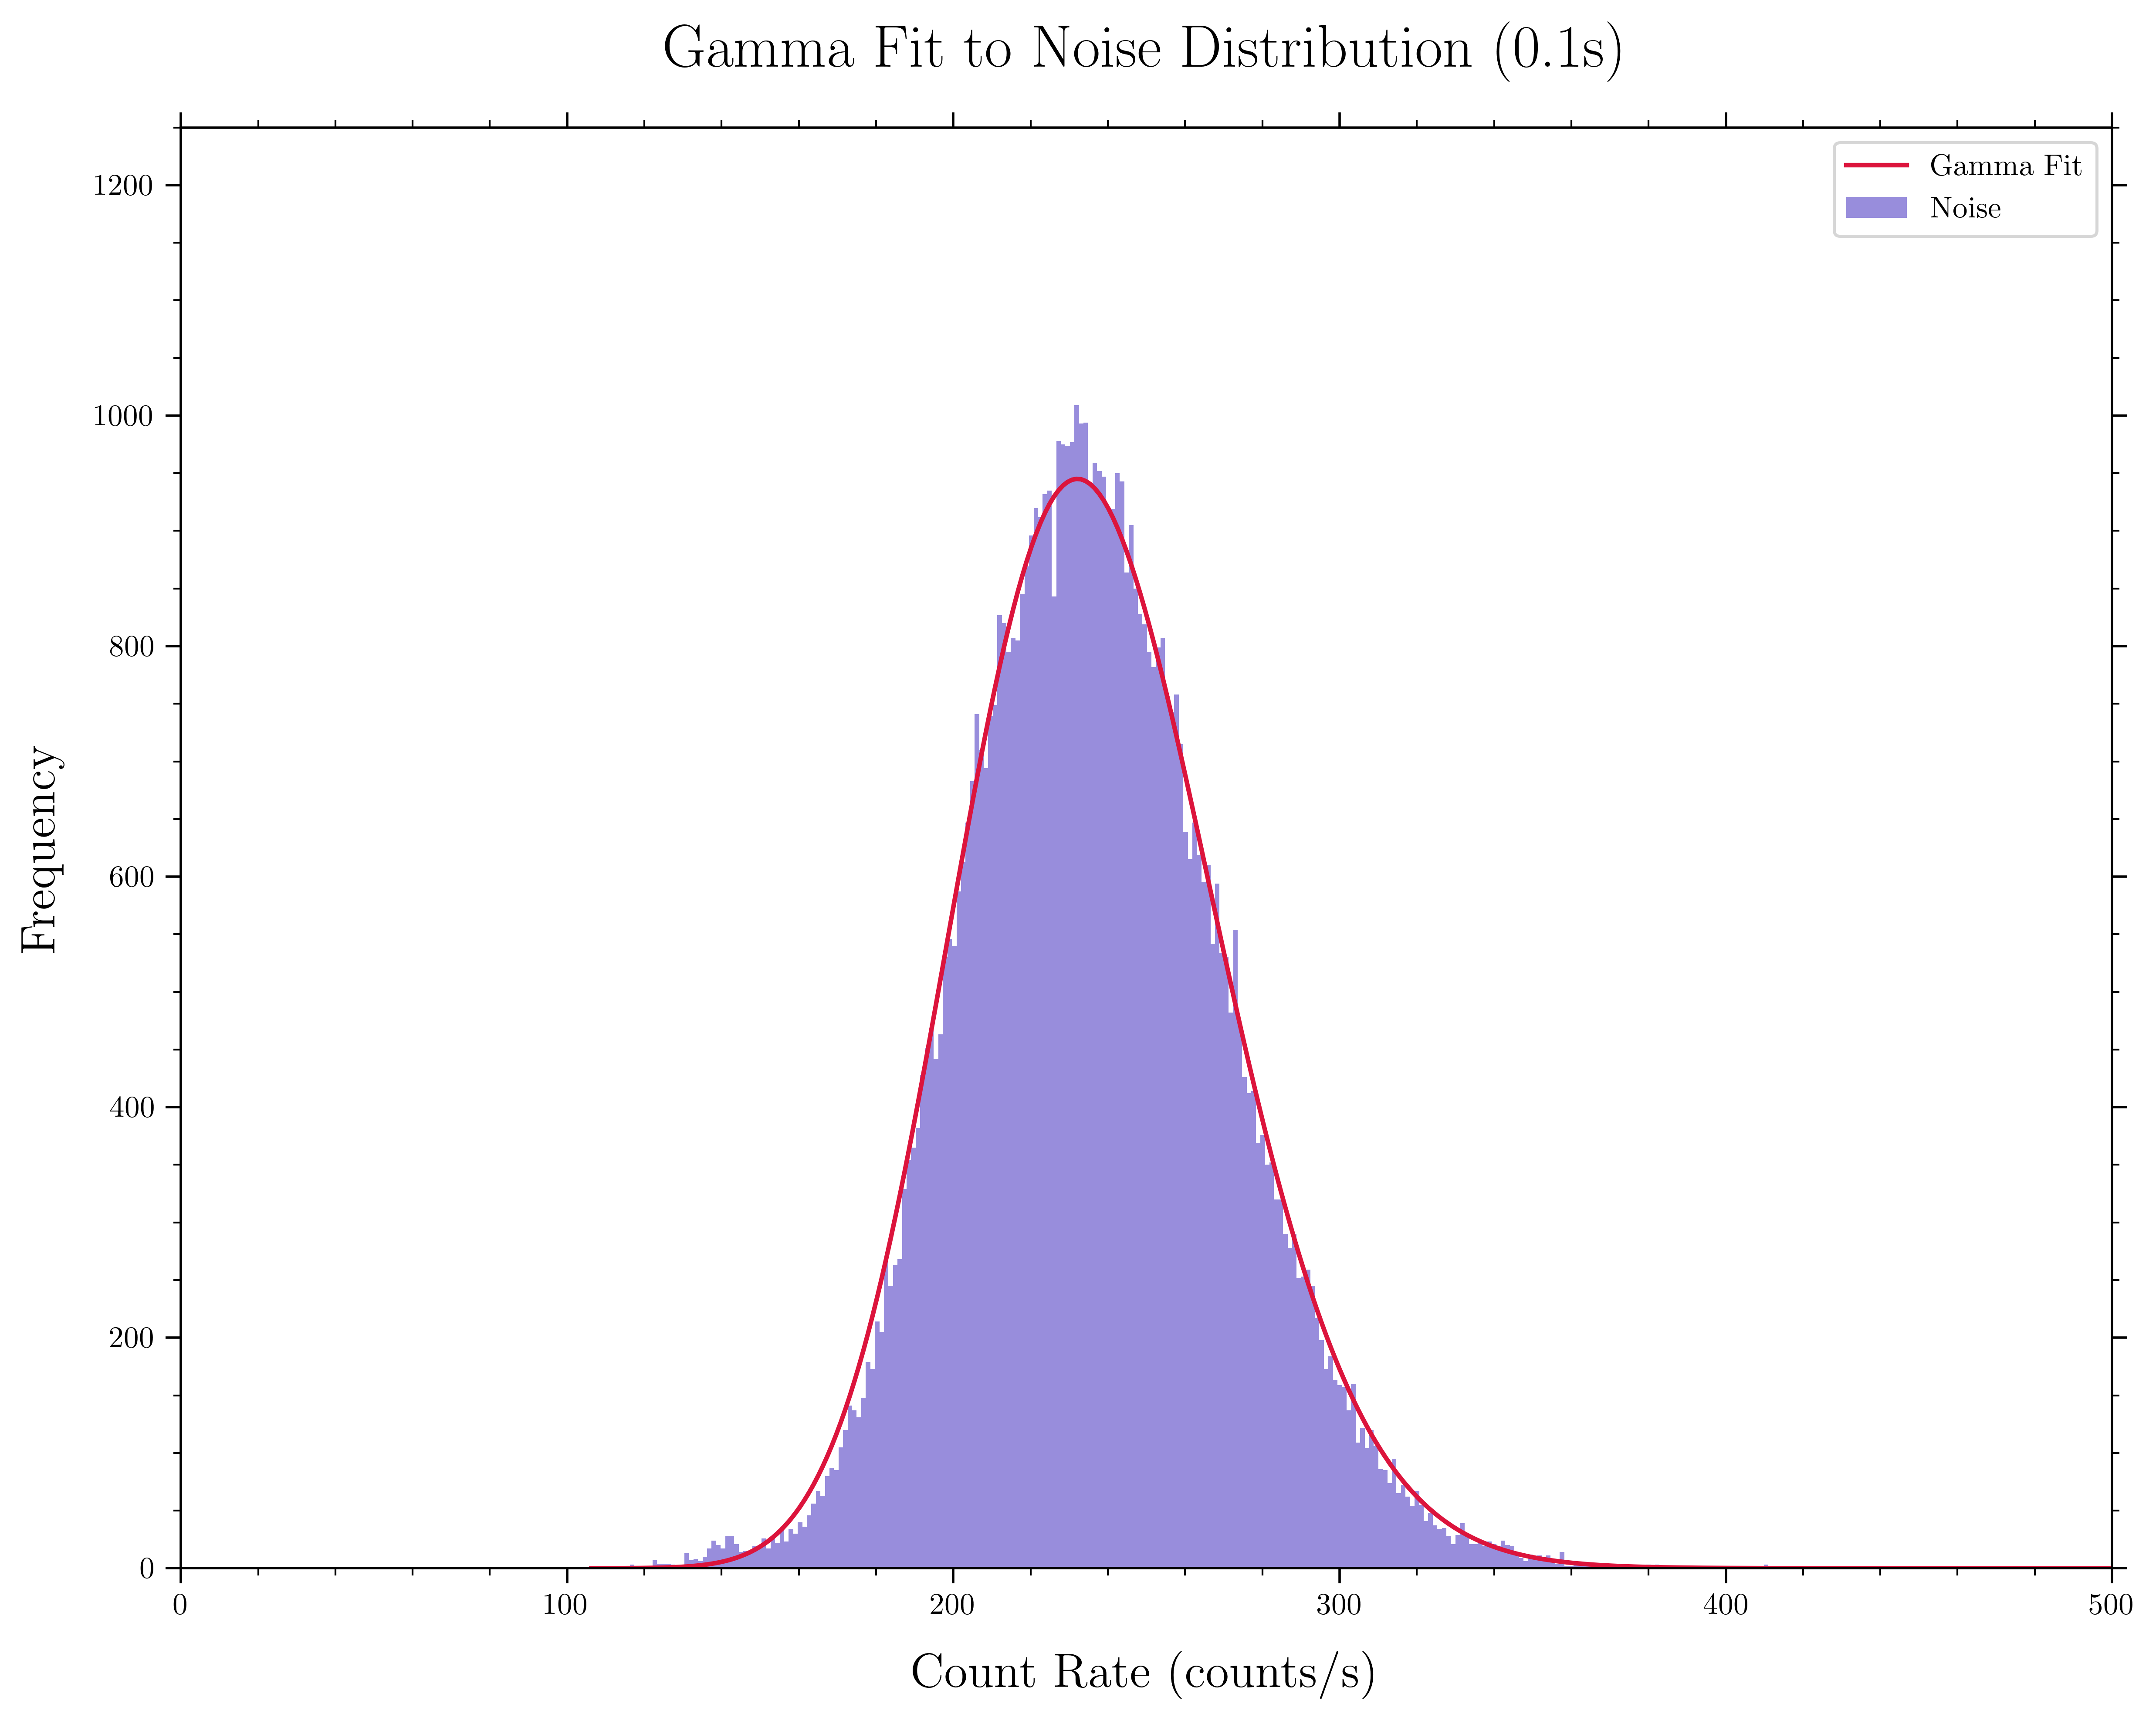

In [5]:
# params = stats.gamma.fit(total_noise)
# k = params[0]
# theta = params[2]
# loc=params[1]
n, bins = np.histogram(total_noise, bins=500)
bin_center = np.array([0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)])
def y(x, c):
    return c*stats.gamma.pdf(x, k, loc=loc, scale=theta)
popt, pcov = opt.curve_fit(y, bin_center, n)

print(k, theta, loc)
plt.figure(figsize=(10, 8), dpi=500)
# plt.plot(bin_center, y, label='Gamma fit', color='red')
plt.plot(bin_center, y(bin_center, popt[0]), label='Gamma fit', color='crimson')
plt.hist(total_noise, bins=bins, label='Noise', color='slateblue', alpha=0.69)
plt.xlim(0,500)
plt.ylim(0, 1250)
plt.title('Gamma Fit to Noise Distribution (0.1s)', fontsize=20, pad=20)
plt.xlabel('Count Rate (counts/s)', fontsize=16, labelpad=10)
plt.ylabel('Frequency', fontsize=16, labelpad=10)
plt.legend(['Gamma Fit', 'Noise'])
plt.tight_layout()
plt.show()

In [7]:
snr = (signal+(k*theta))/(k*theta+3*np.sqrt(k*(theta**2)))
print(snr)

4.392420671589516


In [137]:
def gamma_fit(x, c):
    shape, scale = k, theta
    return c*x**(shape-1)*(np.exp(-x/scale)/(sps.gamma(shape)*scale**shape))

Text(0.5, 1.0, 'Gamma fit to background noise (10s)')

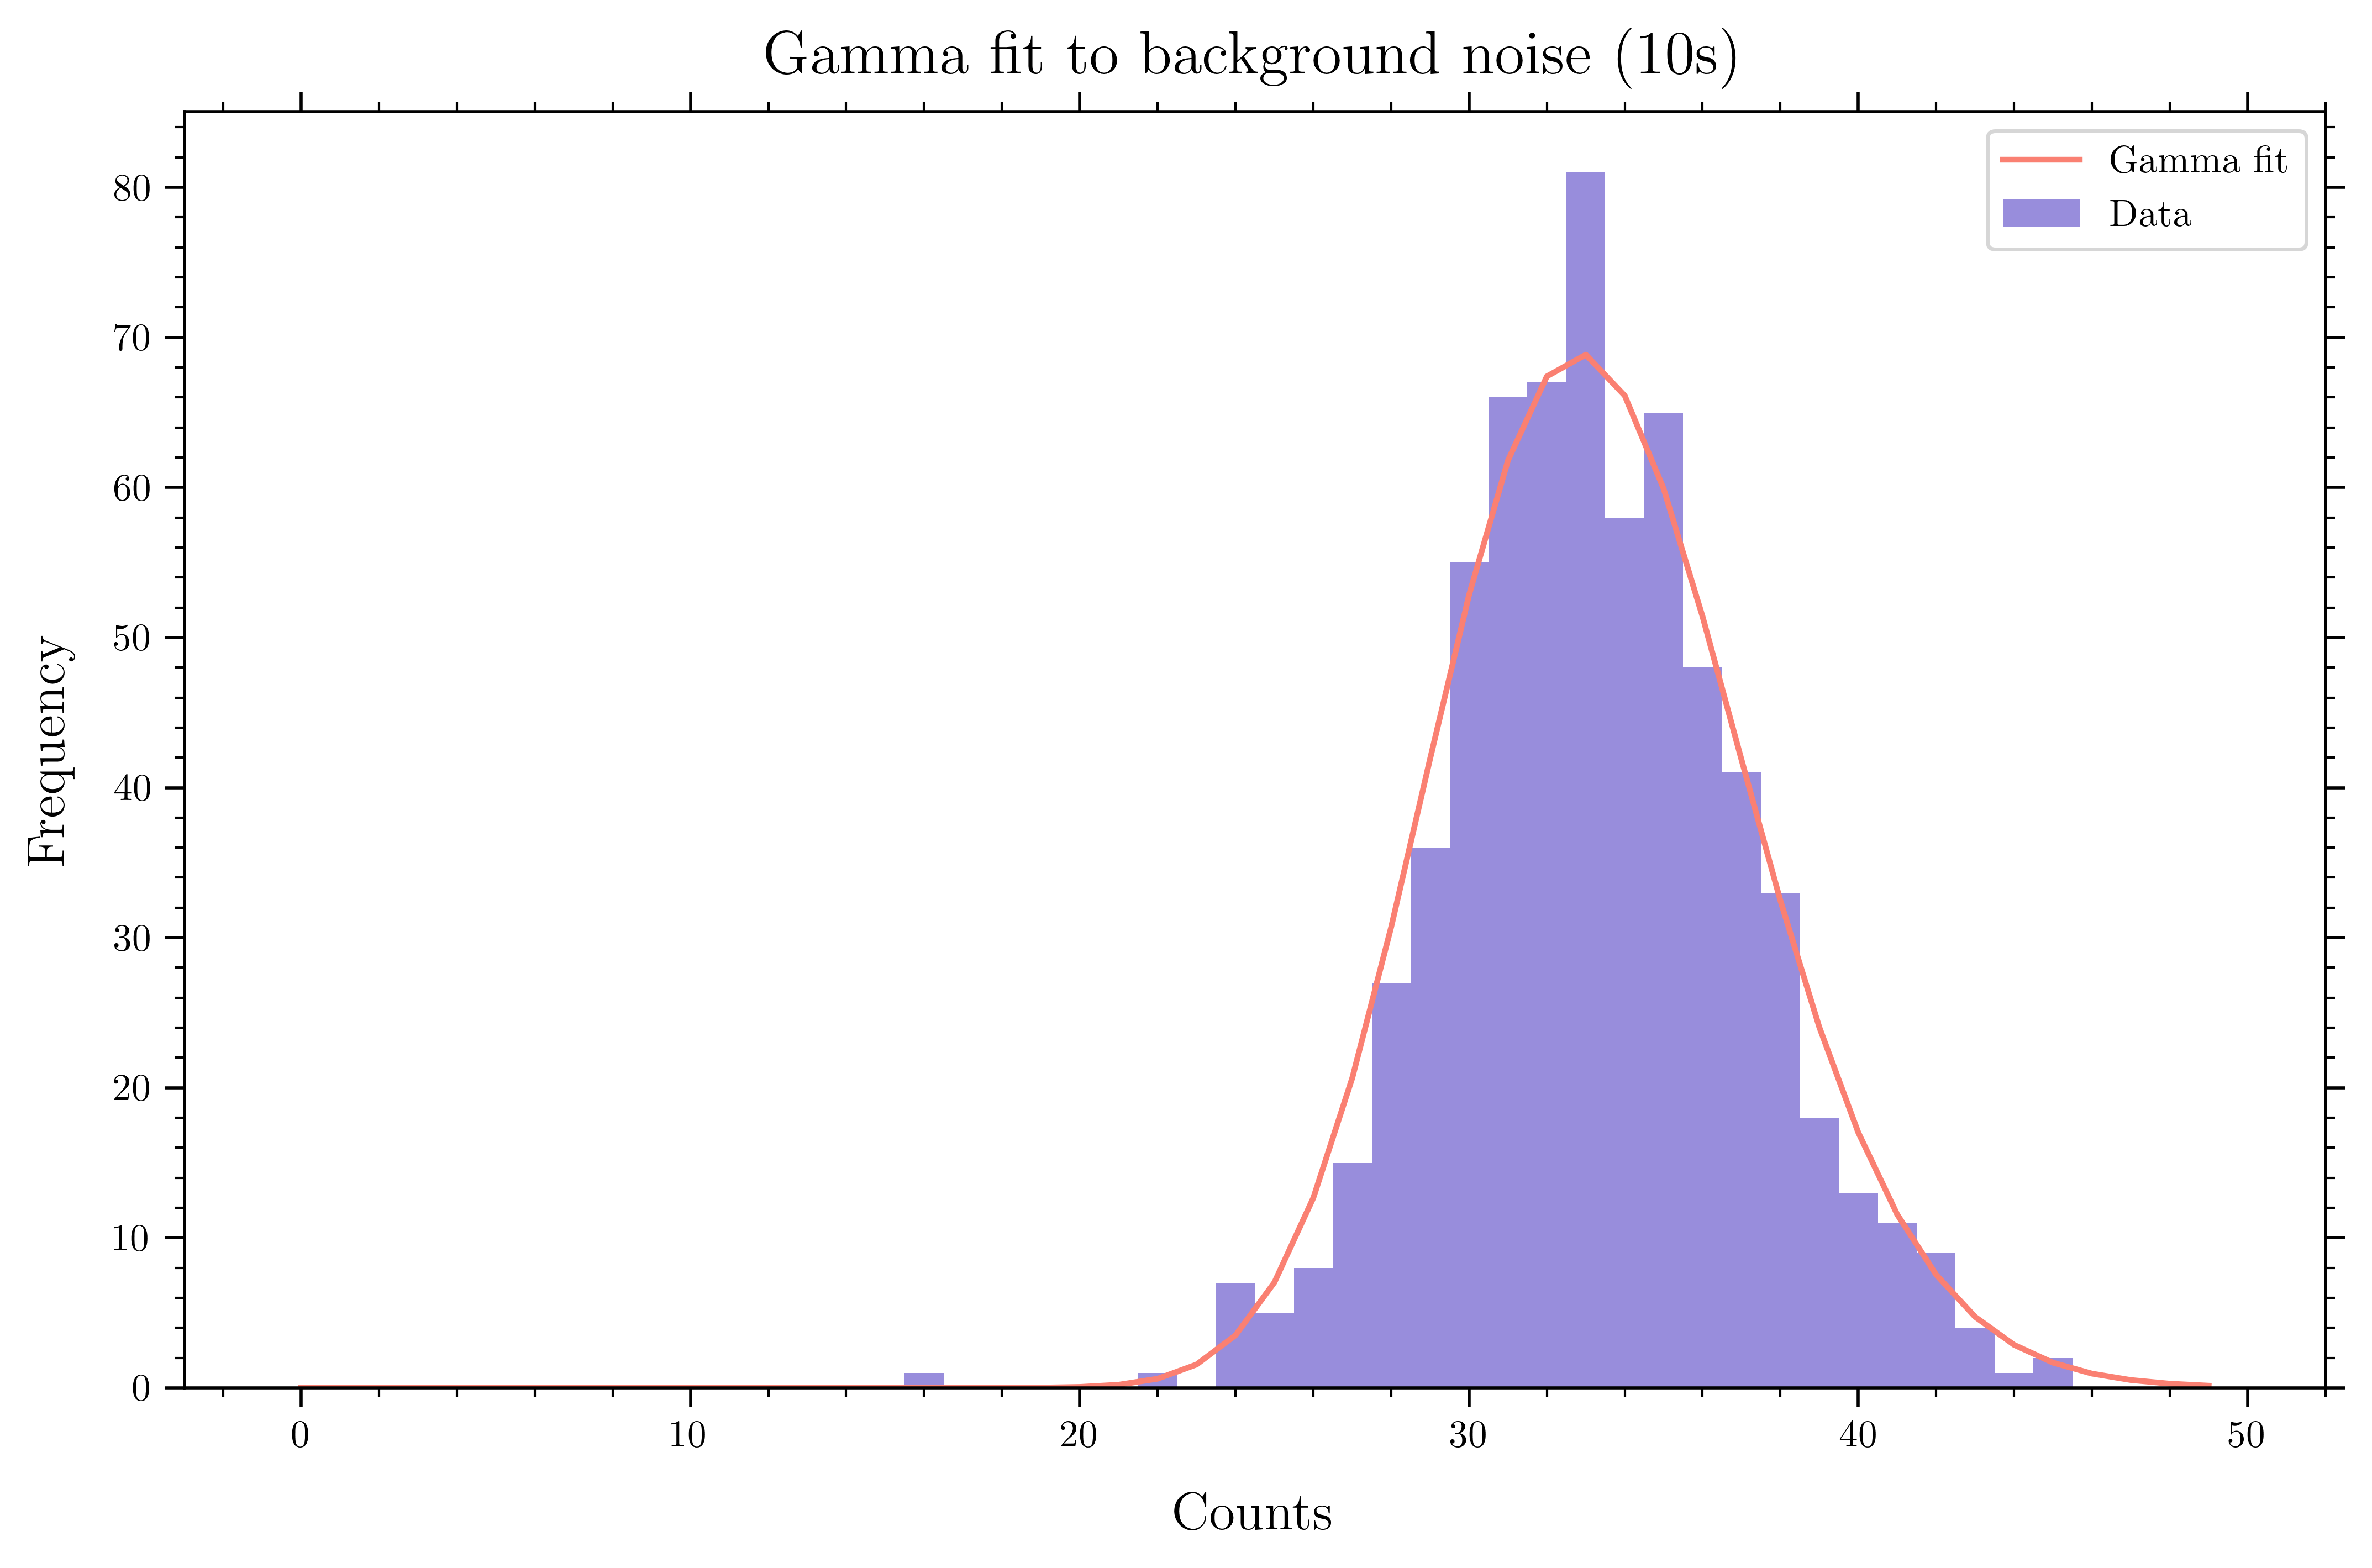

In [119]:
n, bins = np.histogram(total_noise, bins=200)
bin_center = np.array([0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = opt.curve_fit(gamma_fit, bin_center, n)

plt.figure(figsize=(10, 6), dpi=500)
plt.hist(total_noise, bins=200, color='slateblue', label='Data', alpha=0.69)
plt.plot(bin_center, gamma_fit(bin_center, *popt), color='salmon', label='Gamma fit')
plt.legend()
plt.xlabel('Counts', labelpad=10, fontsize=14)
plt.ylabel('Frequency', labelpad=10, fontsize=14)
plt.title('Gamma fit to background noise', pad=10, fontsize=16)